# TSLA Forecasting Model

Our goal is to forecast TSLA's stock price. Because forecasting stocks is an inherently difficult problem, we will begin by using a simple Autoregressive Integrated Moving Average (ARIMA) model to benchmark performance. Although we do not expect are more advanced models to perform exceedingly well, this will help us gauge how well they are fitting.

In [2]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

from statsmodels.tsa.arima_model import ARIMA

from sklearn import utils
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## ARIMA

In [4]:
# Read data
tsla_df = pd.read_csv('TSLA_raw.csv', parse_dates=['Date']) 

# Drop unwanted columns and narrow date range
tsla_df = tsla_df[tsla_df['Date'] > datetime(2019, 9, 1)]

# dates df for later use
dates_df = tsla_df[['Date']]
dates_df = dates_df.reset_index(drop=True).reset_index().rename(columns={'index':'Day'})

tsla_df.set_index('Date', inplace=True)
tsla_series = tsla_df['TSLA'].reset_index(drop=True)

Before we begin fitting our ARIMA model, let's first make sure our data is stationary. A stationary time series is  one whose properties do not depend on the time at which the series is observed. In order for our time series to be stationary, it must meet the following criteria:
    - Constant Mean
    - Constant Variance
    - Constant Autocorrelation

Visually, it should resemble a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations

We will assess our data by comparing TSLA's stock price with 1st and 2nd order differencing and analyzing the ACF plots.

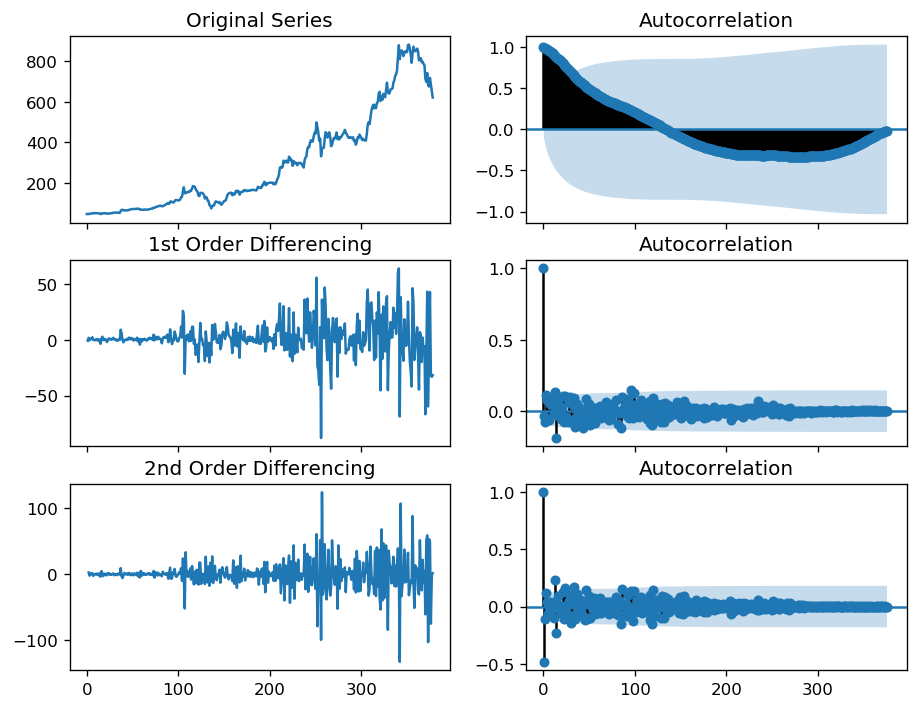

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(tsla_series); axes[0, 0].set_title('Original Series')
plot_acf(tsla_series, ax=axes[0, 1], lags=375)

# 1st Differencing
axes[1, 0].plot(tsla_series.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(tsla_series.diff().dropna(), ax=axes[1, 1], lags=375)

# 2nd Differencing
axes[2, 0].plot(tsla_series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(tsla_series.diff().diff().dropna(), ax=axes[2, 1], lags=375)

plt.show()

In the original series, we observe a strong upward trend. Differencing the data removes the trend and gives us  a constant mean, which is reflected in our autocorrelation plots. However, there appears to be non-constant variance in both the 1st and 2nd order differenced time series.

To further diagnose this, let's fit a simple (1, 1, 1) ARIMA model to the data and see how it performs.

In [6]:
model = ARIMA(tsla_series.diff().dropna().reset_index(drop=True), order=(1,1,1))
model_fit = model.fit()

Text(0.5, 1.0, 'ARIMA(1,1,1) Residuals')

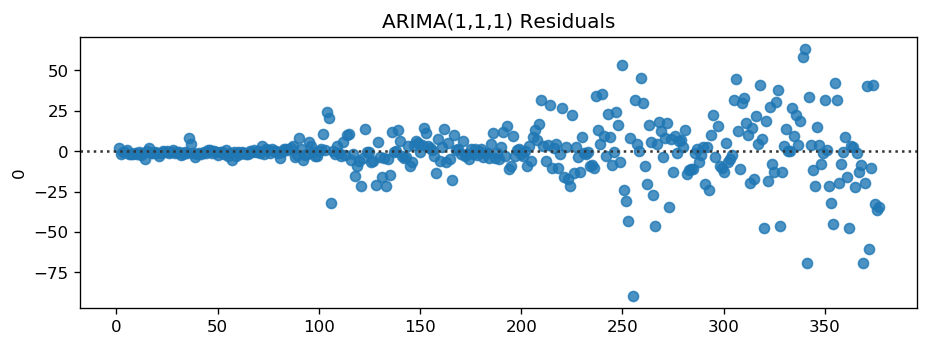

In [7]:
# Residuals
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()
sns.residplot(residuals.index, residuals)
plt.title('ARIMA(1,1,1) Residuals')

As suspected, we observe significant heteroskedasticity in our model, and we can confirm this statistically with the Breusch-Pagan Test. The McLeod Li test would also be appropriate, but is not available in python.

In [8]:
from statsmodels.stats.diagnostic import het_breuschpagan
lagrange_mult, lagrange_p, fstat, fstat_p = het_breuschpagan(residuals.values, np.reshape(residuals.index.values, (-1, 1)))
print(f"Lagrange Multiplier Statistic: {lagrange_mult}")
print(f"F-statistic: {fstat}")
print(f"p-value of F-statistic: {fstat_p}")

Lagrange Multiplier Statistic: 86.57084971712851
F-statistic: 112.07772863686974
p-value of F-statistic: 4.257492071657289e-23


The p-value for the f-statistic is extremely significant, indicating we should reject the null hypothesis that the error variance does not depend on x (time). This confirms that heteroskedasticity is indeed present in our model residuals. In order to handle this, we need to log-transform our data. This should make our variance constant by changing the nature of the data from absolute change to relative change. Let's see how it impacts the data.

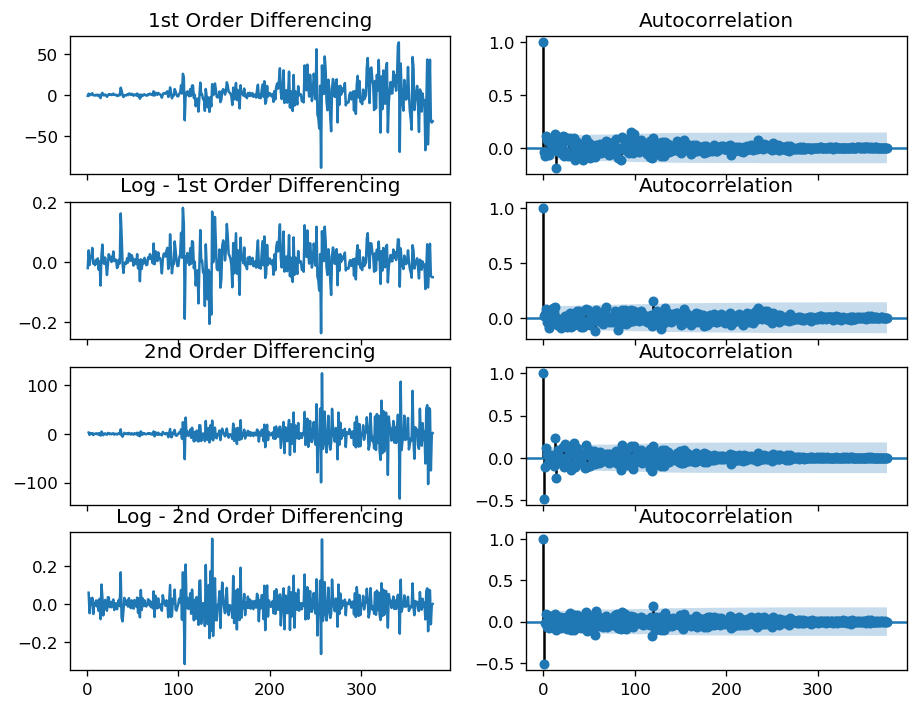

In [9]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# 1st Differencing
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(tsla_series.diff()); axes[0, 0].set_title('1st Order Differencing')
plot_acf(tsla_series.diff().dropna(), ax=axes[0, 1], lags=375)

# Log - 1st Differencing
axes[1, 0].plot(np.log(tsla_series).diff()); axes[1, 0].set_title('Log - 1st Order Differencing')
plot_acf(np.log(tsla_series).diff().dropna(), ax=axes[1, 1], lags=375)

# 2nd Differencing
axes[2, 0].plot(tsla_series.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(tsla_series.diff().diff().dropna(), ax=axes[2, 1], lags=375)

# Log - 2nd Differencing
axes[3, 0].plot(np.log(tsla_series).diff().diff()); axes[3, 0].set_title('Log - 2nd Order Differencing')
plot_acf(np.log(tsla_series).diff().diff().dropna(), ax=axes[3, 1], lags=375)

plt.show()

There are few significant lags in the data, but overall the Log-transformed 2nd-order differenced data resembles white-noise and we can conclude it is weakly stationary. The next step is to select the order for our Autoregressive and Moving Average terms.

We will use the PACF plot to determine the AR term and ACF to determine the MA term.

C:\Users\joshb\.conda\envs\LSTM\lib\site-packages\statsmodels\regression\linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


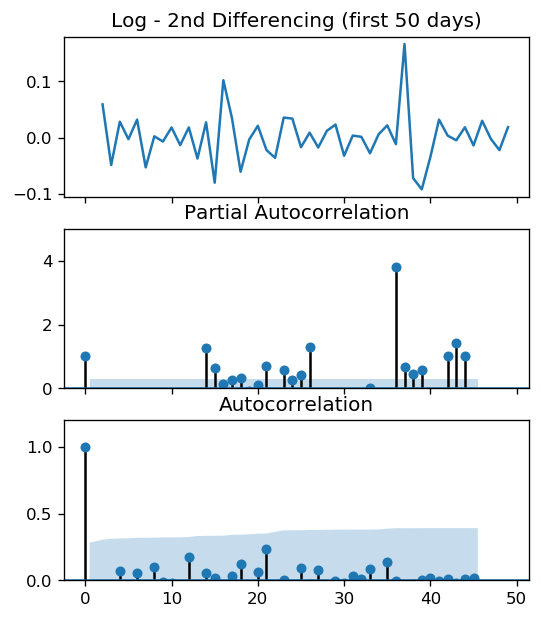

In [10]:
# Determining AR term (p)
plt.rcParams.update({'figure.figsize':(5,6), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 1, sharex=True)


axes[0].plot(np.log(tsla_series[:50]).diff().diff().dropna()); axes[0].set_title('Log - 2nd Differencing (first 50 days)')
axes[1].set(ylim=(0,5))
plot_pacf(np.log(tsla_series[:50]).diff().diff().dropna(), ax=axes[1], lags=45)
axes[2].set(ylim=(0,1.2))
plot_acf(np.log(tsla_series[:50]).diff().diff().dropna(), ax=axes[2], lags=45)

plt.show()

The are very large spikes in some of the lags in the PACF plot, indicating that correlation between observations and their lags is still existing in the data. Because we are using ARIMA as our benchmark model and intend to outperform it with more advanced machine learning algorithms, we are going to accept this and train a model of (1,2,0) using the log-transformed data.

In [11]:
model = ARIMA(np.log(tsla_series[:350]).reset_index(drop=True), order=(1,2,0))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D2.TSLA   No. Observations:                  348
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 479.213
Method:                       css-mle   S.D. of innovations              0.061
Date:                Sat, 20 Mar 2021   AIC                           -952.427
Time:                        11:53:38   BIC                           -940.870
Sample:                             2   HQIC                          -947.826
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -7.46e-06      0.002     -0.003      0.997      -0.004       0.004
ar.L1.D2.TSLA    -0.5195      0.046    -11.367      0.000      -0.609      -0.430
                                    Root

Text(0.5, 1.0, 'ARIMA(1,2,0) Residuals')

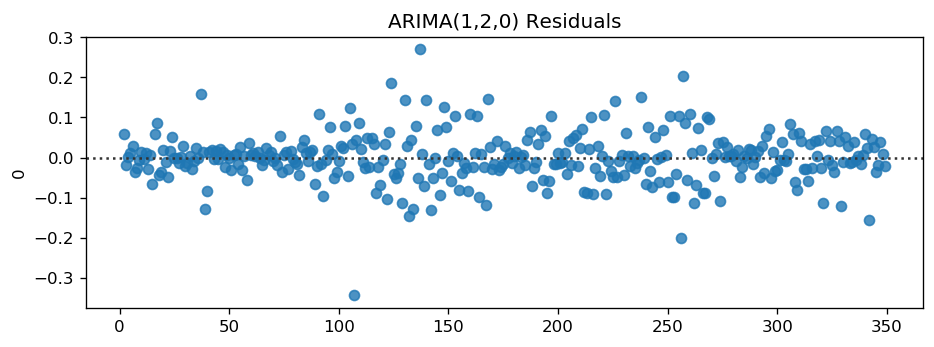

In [12]:
# Residuals
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
residuals = pd.DataFrame(model_fit.resid)
#residuals.plot()
sns.residplot(residuals.index, residuals)
plt.title('ARIMA(1,2,0) Residuals')

Now we observe residuals with a more constant variance, although there are some outliers. There still appears to be some heteroskedasticity present, but it is not heavily skewed like before. Let's go ahead and test our model using the final month of data as our hold-out set. We will predict one day ahead and walk forward, retraining our model with the data available for each new prediction. 

In [14]:
# Forecasting last month of data
training_size = 350
X = np.log(tsla_series).reset_index(drop=True)
train, test = X[0:training_size], X[training_size:len(X)]
history = [x for x in train]
model = ARIMA(train, order=(1,2,0))
model_fit = model.fit()
train_pred = model_fit.predict(start=2, end=training_size-1)
test_pred = []
# walk-forward predictions
for t in range(len(test)):
    model = ARIMA(history, order=(1,2,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    test_pred.append(yhat)
    obs = test[training_size+t]
    history.append(obs)
rmse = math.sqrt(mean_squared_error(test, test_pred))
print(f"Test RMSE: {round(rmse, 3)}")

Test RMSE: 0.053


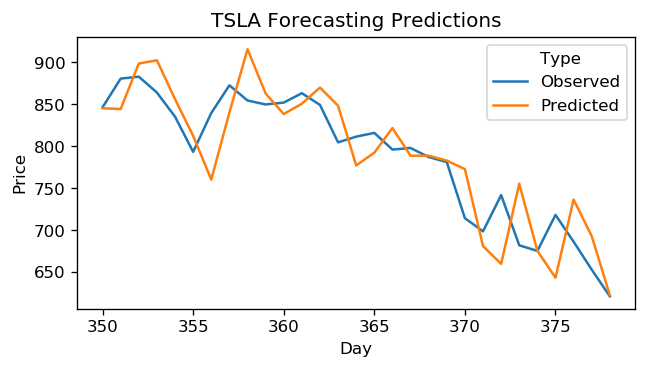

In [15]:
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':120})

# Convert transformed values back to price
test_obs = test.apply(lambda x: np.exp(x))
test_pred = pd.Series(test_pred)
test_pred = test_pred.apply(lambda x: np.exp(x)) 
test_pred = [i[0] for i in test_pred]
test_pred = pd.Series(test_pred)
test_pred.index = range(350, 379)

# Create dataframes and append for visualization
test_obs_df = pd.DataFrame({'Day':test_obs.index, 'Price': test_obs.values})
test_obs_df['Type'] = 'Observed'

test_pred_df = pd.DataFrame({'Day':test_pred.index, 'Price': test_pred})
test_pred_df['Type'] = 'Predicted'

arima_pred = pd.concat([test_obs_df, test_pred_df], ignore_index=True, sort=False)

# Plot
sns.lineplot(data= arima_pred, x="Day", y="Price", hue="Type")
plt.title("TSLA Forecasting Predictions")
plt.show()

Our benchmark score is an RMSE = 0.053

## Random Forest

In this next section, we are going to see how adding more information and leveraging the power of ensemble modeling impacts our ability to predict TSLA's stock price.

#### Prepare Data

Let's read in our data again and start from scratch. In addition to TSLA, our data also includes 11 technical indicators and the S&P 500 ticker (SPY).

In [54]:
# Read data
tsla_df = pd.read_csv('TSLA_raw.csv', parse_dates=['Date']) 

# Drop unwanted columns and narrow date range
tsla_df = tsla_df[['Date','TSLA', 'Volume', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'MOMENTUM', 'RSI', 'EMA','MA10','MA21','MA50',
                   'STD_DEV','SPY']]
tsla_df = tsla_df[tsla_df['Date'] > datetime(2019, 9, 1)]

dates_df = tsla_df[['Date']]
dates_df = dates_df.reset_index(drop=True).reset_index().rename(columns={'index':'Day'})

tsla_df.set_index('Date', inplace=True)
tsla_df.head()

,TSLA,Volume,MACD,MACD_SIGNAL,MACD_HIST,MOMENTUM,RSI,EMA,MA10,MA21,MA50,STD_DEV,SPY
Date,,,,,,,,,,,,,
2019-09-03,45.001999,26770500,-0.727422,-0.843696,0.116274,-0.364002,49.369367,45.250614,43.944800,44.848381,46.47460,0.951591,282.708099
2019-09-04,44.136002,28805000,-0.693270,-0.813611,0.120341,-1.035999,45.946236,45.178704,43.841200,44.775619,46.46276,0.718970,285.916962
2019-09-05,45.916000,36976500,-0.516619,-0.754212,0.237594,1.750000,53.138563,45.226271,44.016200,44.764476,46.50204,0.630387,289.592499
2019-09-06,45.490002,20947000,-0.406312,-0.684632,0.278321,1.060001,51.376658,45.243286,44.122200,44.707619,46.53476,0.591917,289.816193
2019-09-09,46.358002,24013500,-0.246016,-0.596909,0.350893,4.078003,54.674370,45.315203,44.530001,44.645619,46.57056,0.767633,289.962036


Let's visualize each series individually to gain a better intuition.

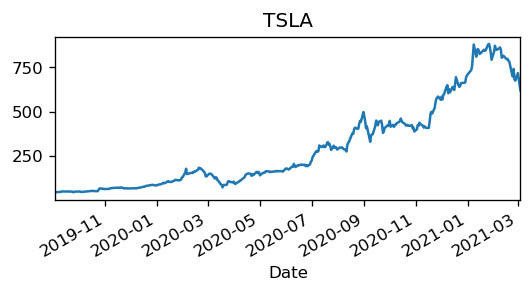

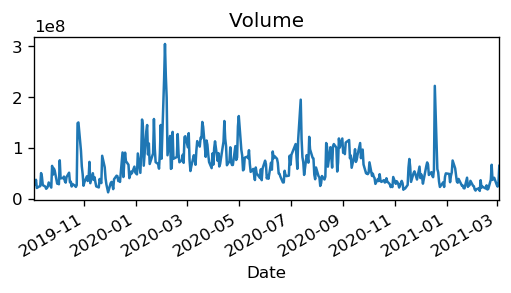

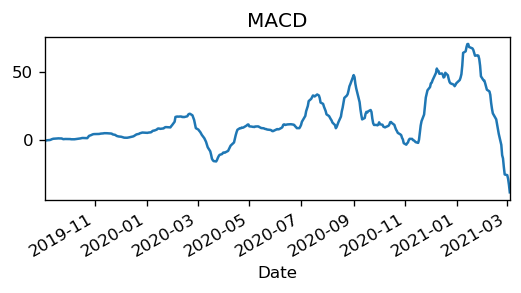

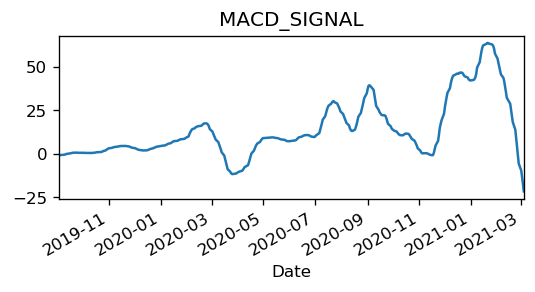

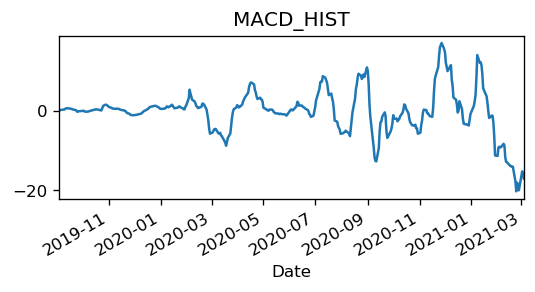

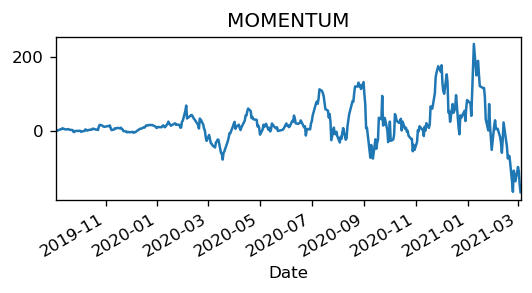

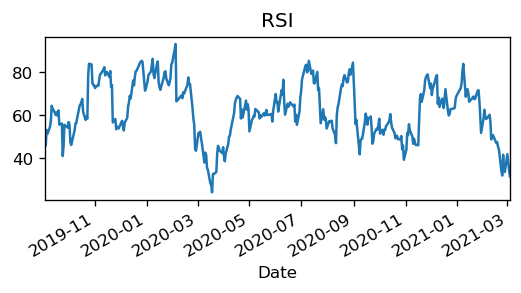

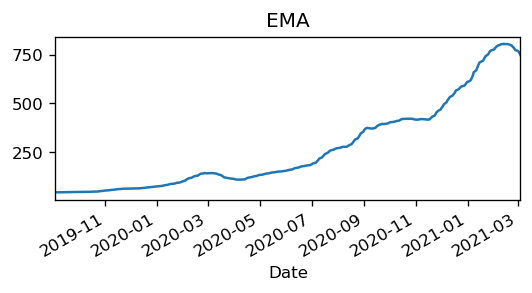

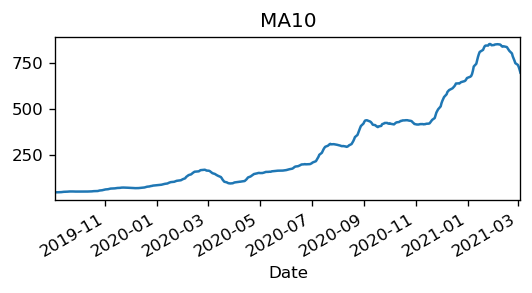

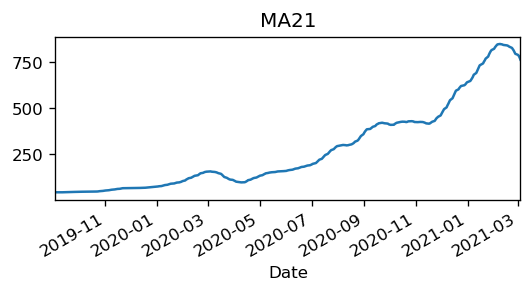

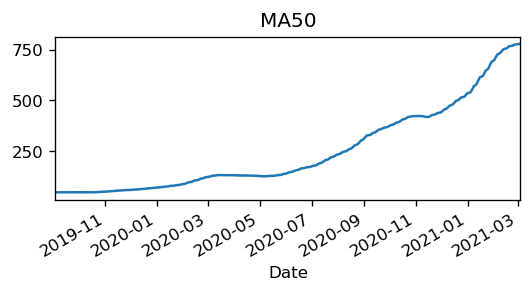

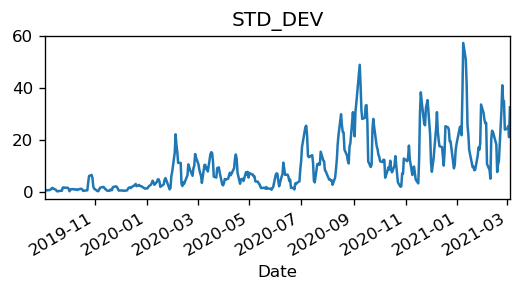

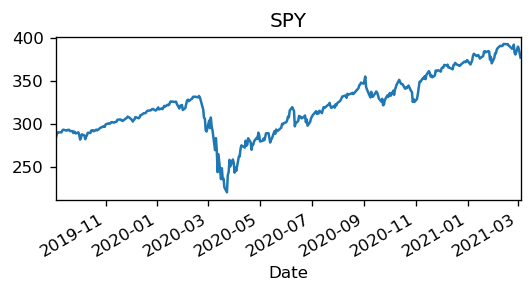

In [17]:
# Visualize all variables over time
plt.rcParams.update({'figure.figsize':(5,2), 'figure.dpi':120})
for c in list(tsla_df.columns):
    tsla_df[c].plot()
    plt.title(c)
    plt.show()

#### Add Sentiment Data

We are also going to add our scores from our r/wallstreetbets sentiment analysis.

In [55]:
# Read in sentiment scores
wsb_df = pd.read_csv('.//Sentiment Analysis//Sentiment Scores.csv')
wsb_df['Created_EST'] = wsb_df['Created_EST'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
wsb_df = wsb_df.sort_values(by='Created_EST')
wsb_df = wsb_df[wsb_df['Created_EST'] > datetime(2019, 9, 1)].reset_index(drop=True)
wsb_df = wsb_df.fillna(method="pad")

# Because the data collected early on is such low volume, we are going to interpolate values for outliers that deviate 
# too far from the mean
wsb_df['interp'] = wsb_df['avg'].rolling(min_periods=1, center=True, window=12).mean()
wsb_df['avg'] = wsb_df.apply(lambda row: row['interp'] if (((row['Created_EST'] < datetime(2020,1,1)) & 
                                                           ((row['avg'] < 0.5) | (row['avg'] > 0.99))) |
                                                          (row['count'] < 10)) 
                             else row['avg'], axis=1)

We need to further aggregate our sentiment scores collected daily including weekends and holidays to join on our dataset that only reflects days the market is open for trading.

In [57]:
# Reaggregate sentiment scores based on market open days
wsb_df['join'] = 1
tsla_df['join'] = 1
tsla_df = tsla_df.reset_index()
wsb_df = tsla_df[['Date','TSLA','join']].merge(wsb_df, how='inner', on='join')

wsb_df = wsb_df[wsb_df['Created_EST'] <= wsb_df['Date']]
wsb_df = wsb_df.sort_values(by=['Date','Created_EST']).reset_index(drop=True)
wsb_df = wsb_df.drop_duplicates(subset='Created_EST')

adj_wsb_df = wsb_df.groupby('Date').apply(lambda x: pd.Series({
                                        'Weighted Sentiment Score': x['weighted_avg'].mean(),
                                        'Sentiment Score': x['avg'].mean(),
                                        'WB Score': x['wb'].mean(),
                                        'VADER Score': x['vader'].mean(),
                                        'Comment Volume': x['count'].sum()
                                        })).reset_index()

adj_wsb_df = adj_wsb_df.fillna(method="bfill")

In [58]:
# Join sentiment scores on TSLA
tsla_df = tsla_df.merge(adj_wsb_df, how='left', on='Date')

# Imputing missing values in sentiment
tsla_df = tsla_df.fillna(method="pad")

# Drop join column
tsla_df = tsla_df.drop('join', axis=1)

# backfill missing wsb data
tsla_df[['Sentiment Score','Weighted Sentiment Score','WB Score','VADER Score','Comment Volume']] = \
    tsla_df[['Sentiment Score','Weighted Sentiment Score','WB Score','VADER Score','Comment Volume']].fillna(method="bfill")

After comparison of the different scores, we have chosen to only include the original sentiment score in our model, omitting the weighted score, word bank score, and VADER score.

In [59]:
# drop unused sentiment scores
drop_cols = ['Weighted Sentiment Score','WB Score','VADER Score']
for col in drop_cols:
    tsla_df = tsla_df.drop(col, axis=1)

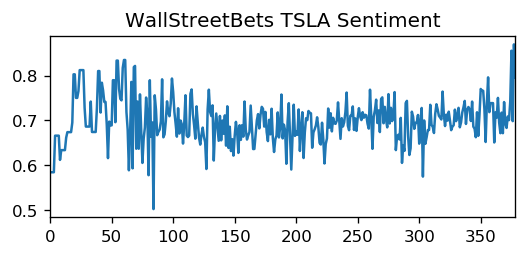

In [23]:
tsla_df['Sentiment Score'].plot()
plt.title('WallStreetBets TSLA Sentiment')
plt.show()

Either our sentiment analysis could be improved, or this shows us that the community's devotion to Tesla is so strong that sentiment remains extremely bullish regardless of changes in the stock price. In the future it may be worth pulling data from other sources, such as Twitter to gather sentiment from a less biased group.

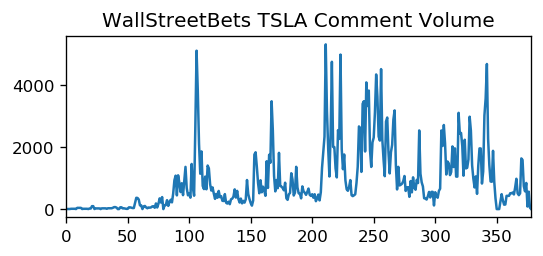

In [24]:
tsla_df['Comment Volume'].plot()
plt.title('WallStreetBets TSLA Comment Volume')
plt.show()

Volume on the otherhand appears to have some more variability. Perhaps this is correlated with the price and reflective of the group's excitement when TSLA is trading more actively. Let's plot against price to see if there is any merit to our hypothesis.

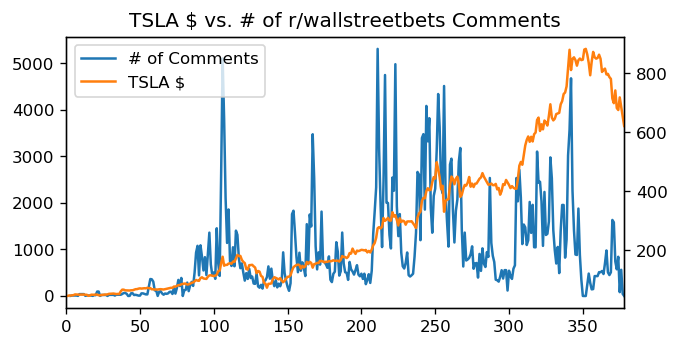

In [15]:
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':120})
tsla_df['Comment Volume'].plot(label="# of Comments", legend=True, title="TSLA $ vs. # of r/wallstreetbets Comments")
tsla_df['TSLA'].plot(secondary_y=True, label="TSLA $", legend=True, mark_right=False)

The plot shows large spikes in comment volume when TSLA is making an upward move. Volume tends to taper off when TSLA is trading side-ways, so this information may be useful.

#### Transform data and force time components into model

Now that we have all our variables, we need to prepare the data to fit our model. Because machine learning models do not consider the sequence of data in time like ARIMA does, we need to introduce time into the model using several dummy variables and lagged variables. We should also make our data stationary using differencing and log-transformations. In doing so, we will be transforming our target variable to predict the relative change in price instead of the absolute change in price.

In [60]:
def transform_series(df, col, log=False):
    """Log-transform and difference time series"""
    # add constant to series with negative values before log-transformation
    if log == True:
        if min(df[col]) < 0:
            df[col] += min(df[col])*-1
        df[col] = np.log(df[col]).replace(-np.inf,0).diff()
    else:
        df[col] = df[col].diff()
    return df

#Log-transform and difference time series
log_transform_cols = ['TSLA','EMA', 'MA10', 'MA21', 'MA50', 'STD_DEV', 'SPY']

reg_transform_cols = ['MACD','MACD_SIGNAL','MACD_HIST','MOMENTUM','RSI','Volume','Comment Volume']

for col in log_transform_cols:
    tsla_df = transform_series(tsla_df, col, log=True)
    
for col in reg_transform_cols:
    tsla_df = transform_series(tsla_df, col)

In [61]:
# scale volume
scaler = preprocessing.MinMaxScaler()
tsla_df[['Volume','Comment Volume']] = scaler.fit_transform(tsla_df[['Volume','Comment Volume']])

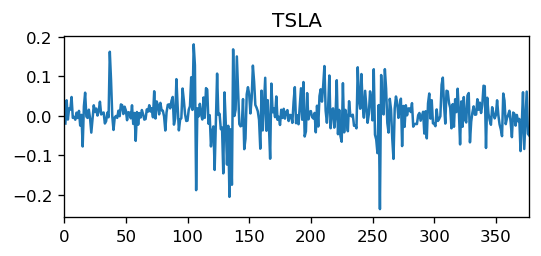

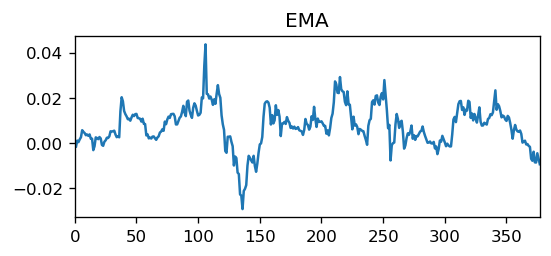

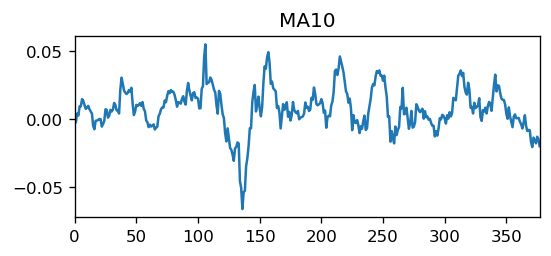

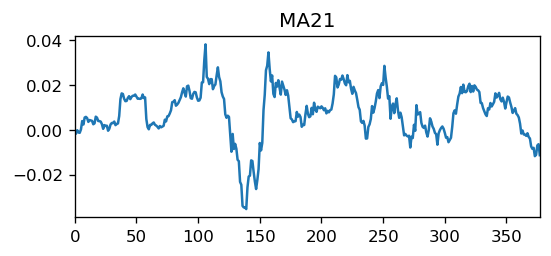

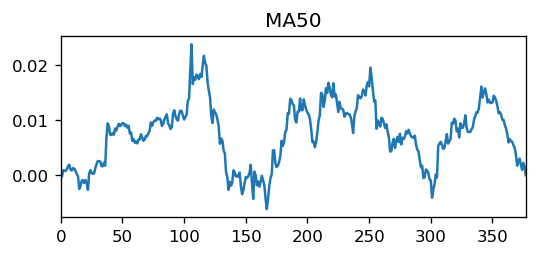

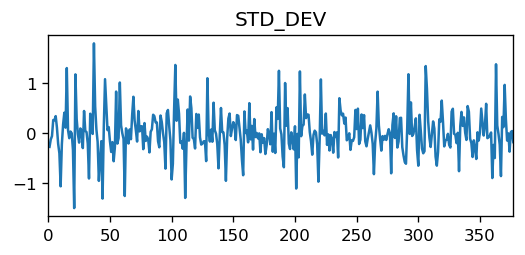

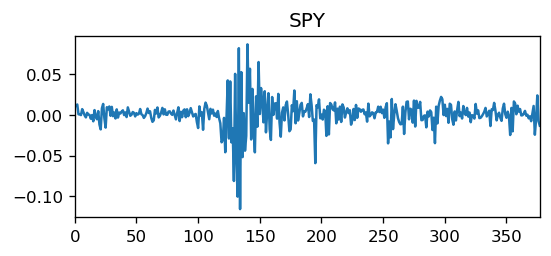

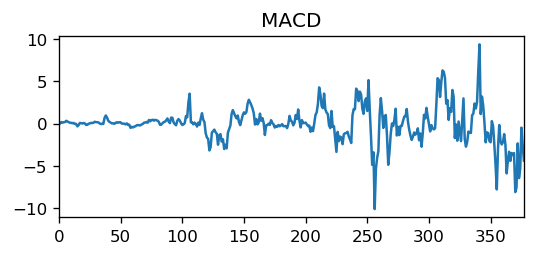

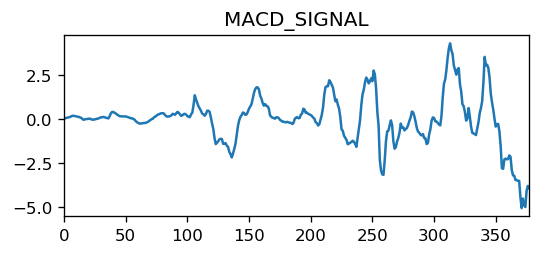

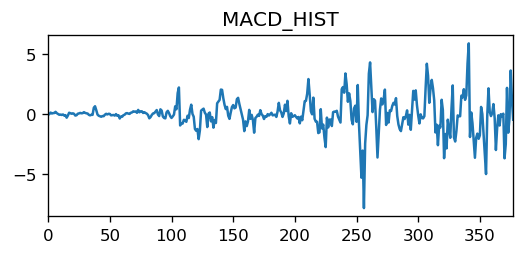

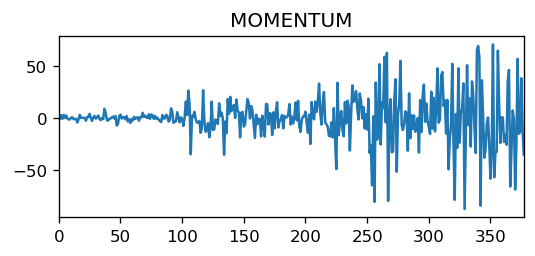

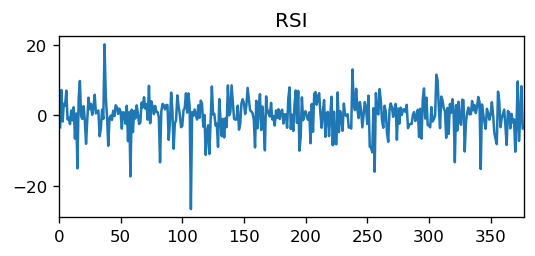

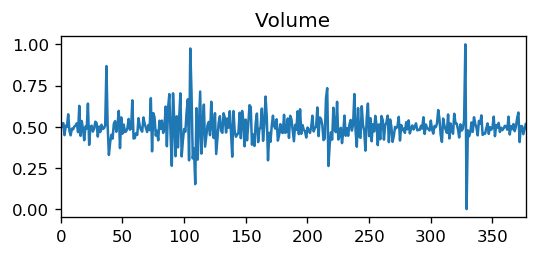

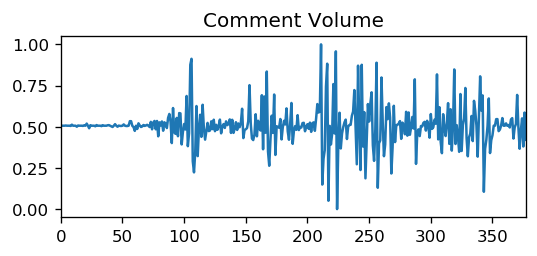

In [45]:
# Visualize all variables over time
plt.rcParams.update({'figure.figsize':(5,2), 'figure.dpi':120})
for c in list(log_transform_cols+reg_transform_cols):
    tsla_df[c][:-1].plot()
    plt.title(c)
    plt.show()

Now that we have made our features more stationary, we can add our time dummy variables.

In [62]:
# Add dummy variables
tsla_df['Day'] = tsla_df.index
tsla_df['Monthday'] = tsla_df['Date'].apply(lambda x: int(x.strftime('%d')))
tsla_df['Week'] = tsla_df['Date'].apply(lambda x: int(x.strftime('%W')))
tsla_df['Weekday'] = tsla_df['Date'].apply(lambda x: int(x.strftime('%w')))
tsla_df['Month'] = tsla_df['Date'].apply(lambda x: int(x.strftime('%m')))
tsla_df['Year'] = tsla_df['Date'].apply(lambda x: int(x.strftime('%y')))

# Drop Date variable
tsla_df = tsla_df.drop('Date', axis=1)

#### Correlation Matrix

Let's take a look at the correlation plot of our variables to get a sense of whether or not there is multi-collinearity present in our independent variables.

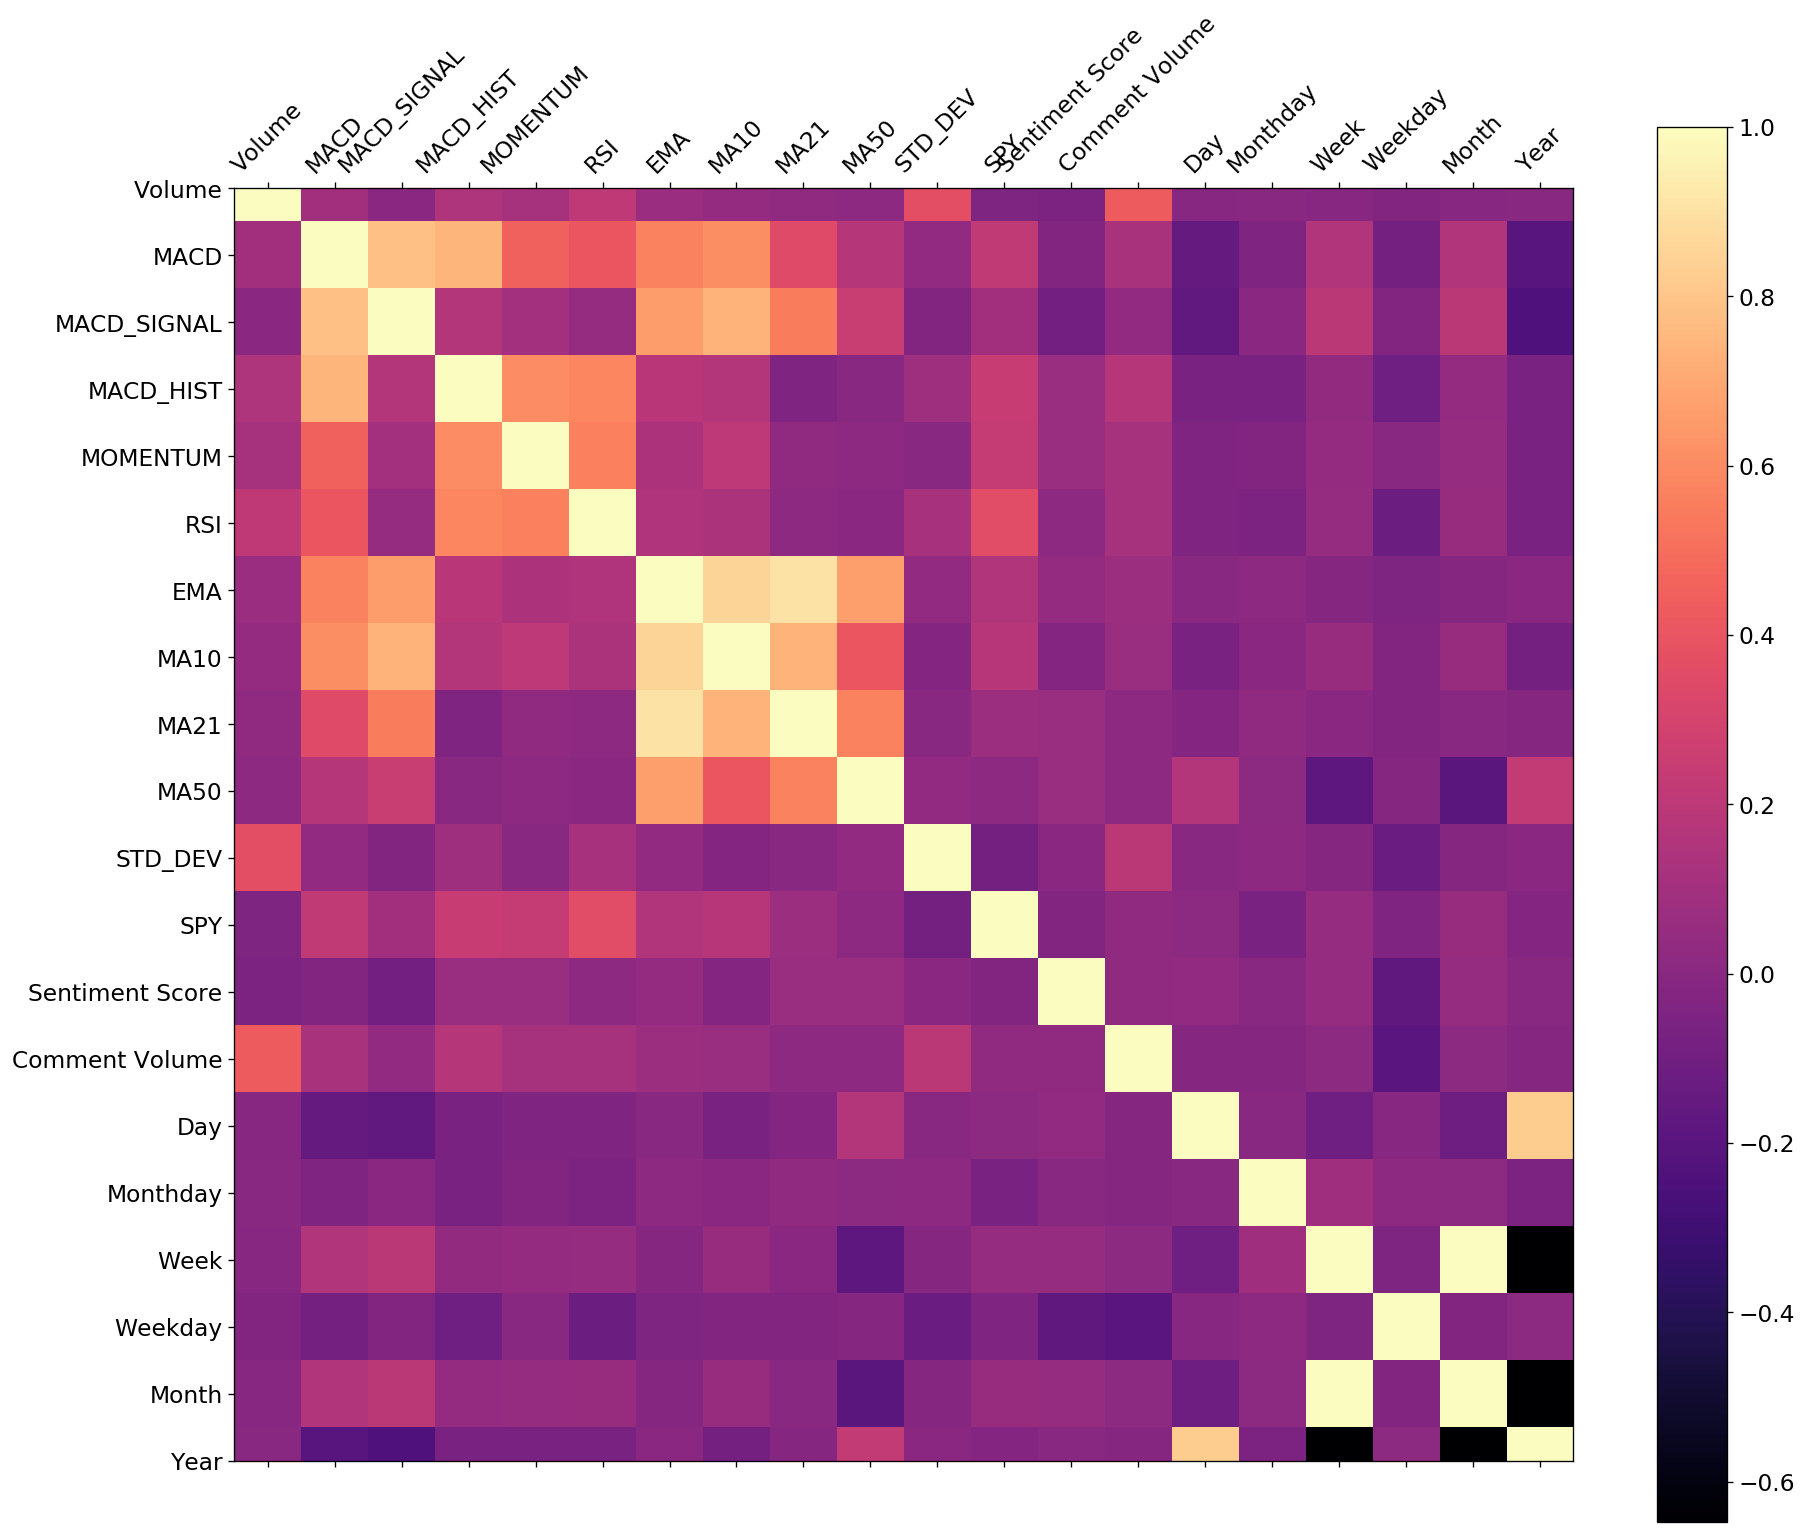

In [63]:
df = tsla_df.iloc[1:,1:]

f = plt.figure(figsize=(18, 15))
plt.matshow(df.corr(), fignum=f.number, cmap='magma') #inferno
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

The moving average indicators are highly correlated with one another. They also have a strong relationship with the MACD indicators. We can consider removing some of these from our model.

We still have one more step remaining, which is to add lagged variables to our features to allow our model to pick up on the sequence of our time series.

In [64]:
# Add lagged variables
for col in list(tsla_df.columns):
    tsla_df[col+'(t-1)'] = tsla_df[col].shift(1)
    
# Add target variable
tsla_df['TSLA(t+1)'] = tsla_df['TSLA'].shift(-1)

# Drop first two rows
tsla_df = tsla_df.iloc[2:,:].reset_index(drop=True)

In [65]:
# Bring target variable to front
tsla_cols = list(tsla_df.columns)
target_col = tsla_cols.pop()
tsla_cols = [target_col]+tsla_cols
tsla_df = tsla_df[tsla_cols]

In [66]:
tsla_df.head()

,TSLA(t+1),TSLA,Volume,MACD,MACD_SIGNAL,MACD_HIST,MOMENTUM,RSI,EMA,MA10,...,STD_DEV(t-1),SPY(t-1),Sentiment Score(t-1),Comment Volume(t-1),Day(t-1),Monthday(t-1),Week(t-1),Weekday(t-1),Month(t-1),Year(t-1)
0,-0.009321,0.039538,0.522077,0.176652,0.059398,0.117253,2.785999,7.192328,0.001052,0.003984,...,-0.280315,0.011287,0.583838,0.506230,1.0,4.0,35.0,3.0,9.0,19.0
1,0.018901,-0.009321,0.448726,0.110307,0.069580,0.040727,-0.689999,-1.761905,0.000376,0.002405,...,-0.131486,0.012773,0.583838,0.506230,2.0,5.0,35.0,4.0,9.0,19.0
2,0.016049,0.018901,0.506604,0.160295,0.087723,0.072572,3.018002,3.297713,0.001588,0.009200,...,-0.062968,0.000772,0.583838,0.506230,3.0,6.0,35.0,5.0,9.0,19.0
3,0.047912,0.016049,0.498537,0.188220,0.107823,0.080398,0.029999,2.690668,0.002549,0.009183,...,0.259945,0.000503,0.665584,0.507393,4.0,9.0,36.0,1.0,9.0,19.0
4,-0.004990,0.047912,0.575493,0.332557,0.152770,0.179788,2.495995,7.018949,0.005649,0.014588,...,0.254411,-0.000235,0.665584,0.506230,5.0,10.0,36.0,2.0,9.0,19.0


#### Train Model

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
training_size = 350
horizon = 1

# Training data
X = tsla_df.iloc[:training_size-horizon,1:]
y = tsla_df.iloc[:training_size-horizon,0]    

# Random Forest 
regr = RandomForestRegressor(n_estimators=100, random_state=0)
regr.fit(X, y)     

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

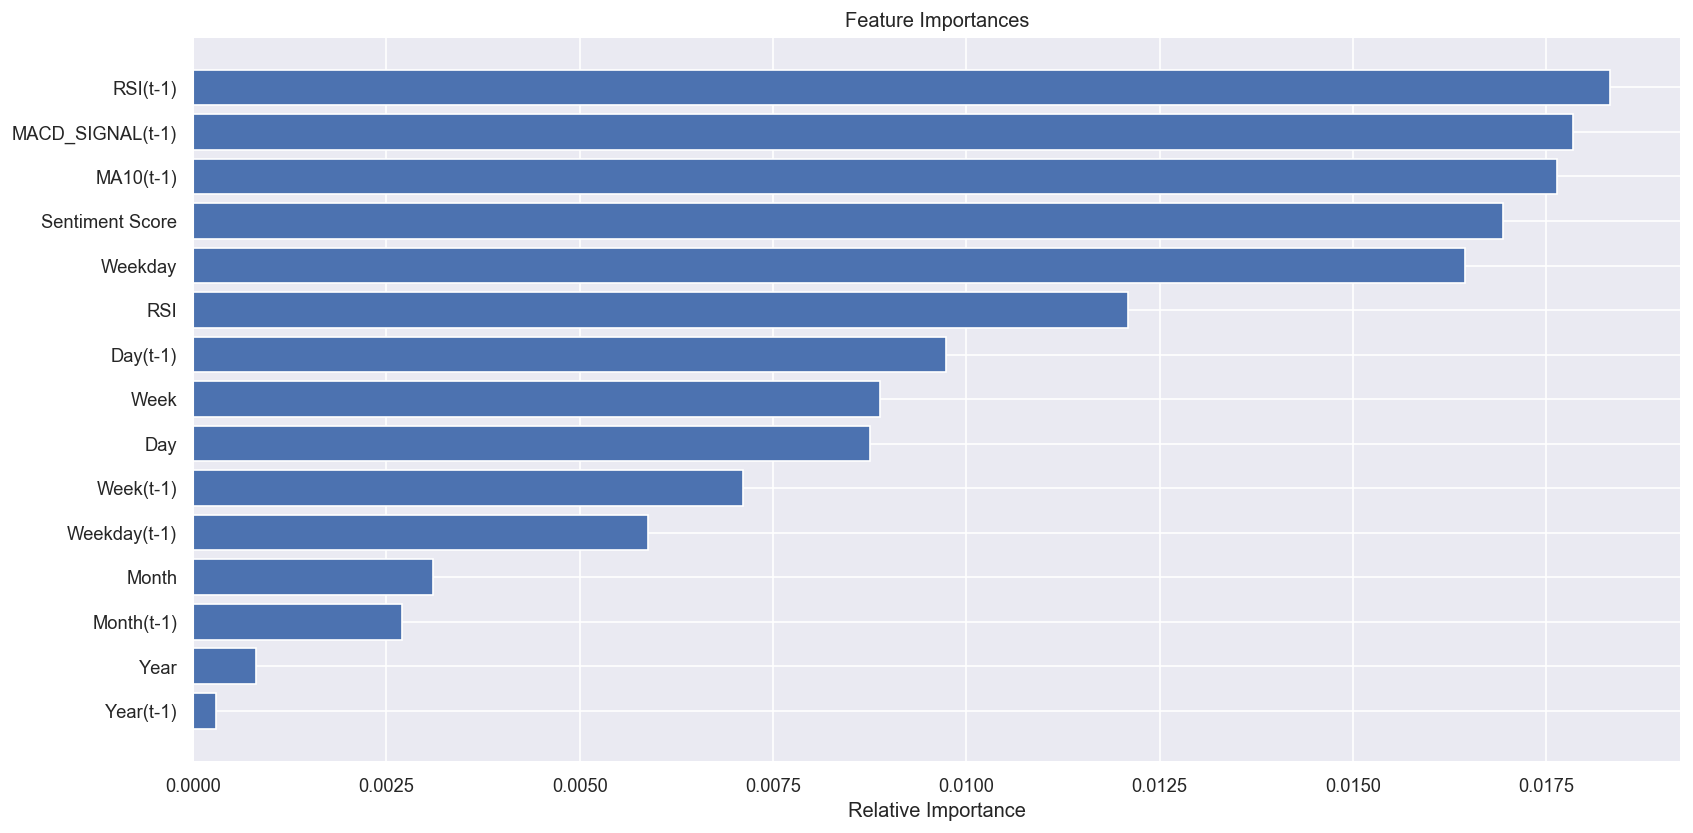

In [69]:
# Feature Importance
features = list(tsla_df.columns)[1:]
importances = regr.feature_importances_
indices = np.argsort(importances)

# Top Features
indices = indices[:15]

sns.set(rc={'figure.figsize':(16, 8)})

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Test model on last month of data

In [70]:
# Random Forest   
training_size = 350

# Split train and test sets (test = 30 days)
X = tsla_df.iloc[:,1:]
y = tsla_df.iloc[:,0] 
X_train, X_test = X.iloc[0:training_size,:], X.iloc[training_size:X.shape[0],:]
y_train, y_test = y[0:training_size], y[training_size:len(y)]

# train model
regr = RandomForestRegressor(n_estimators=100, random_state=0)
regr.fit(X_train, y_train)  

train_pred = regr.predict(X_train)
y_true = y_train.values
test_pred = []

# walk-forward predictions 
for t in range(training_size, X.shape[0]-1):
    regr.fit(X.iloc[:t,:], y[:t]) 
    yhat = regr.predict(X.iloc[t,:][:,None].T) #reshape with broadcasting
    test_pred.append(yhat)
    obs = y[t]
rmse = math.sqrt(mean_squared_error(y_test.values[:-1], test_pred))
print(f"Test RMSE: {round(rmse, 3)}")

Test RMSE: 0.046


The Random Forest outperformed our ARIMA model's baseline of 0.053 by 13% with an RMSE of 0.046.

In [71]:
# Prep predictions for visual
train_pred = [i for i in train_pred]
test_pred = [i[0] for i in test_pred]
pred = train_pred + test_pred
pred = pd.Series(pred)
pred_df = pd.DataFrame({'Day':pred.index, 'Price':pred})

# Add 1 Day index for one-day forecast predictions
pred_df['Day'] +=1
pred_df.index += 1

In [72]:
# Recover Price from predictions
tsla_prices = pd.read_csv('TSLA_raw.csv', parse_dates=['Date'])
tsla_prices = tsla_prices[tsla_prices['Date'] > datetime(2019, 9, 1)].reset_index(drop=True)

# Get series of prices - lagging by 1 to account for differencing
tsla_prices = np.log(tsla_prices['TSLA'])[1:].reset_index(drop=True) 

pred_df = pred_df.merge(tsla_prices.to_frame(), left_index=True, right_index=True)
pred_df['Price'] = pred_df['Price'] + pred_df['TSLA']

pred_df['Recovered Price'] = np.exp(pred_df['Price'])
pred_df['Type'] = 'Predicted'
pred_df = pred_df.drop('TSLA', axis=1)
pred_df = pred_df.rename(columns={'Recovered Price':'TSLA'})
pred_df = pred_df[['Day','TSLA','Type']]

In [73]:
obs_df = pd.read_csv('TSLA_raw.csv', parse_dates=['Date'])
obs_df = obs_df[obs_df['Date'] > datetime(2019, 9, 4)].reset_index(drop=True) # drop first 3 values
obs_df['Type'] = 'Observed'
obs_df['Day'] = obs_df.index
obs_df = obs_df[['Day','TSLA','Type']]
rf_pred = pd.concat([obs_df, pred_df], ignore_index=True, sort=False)

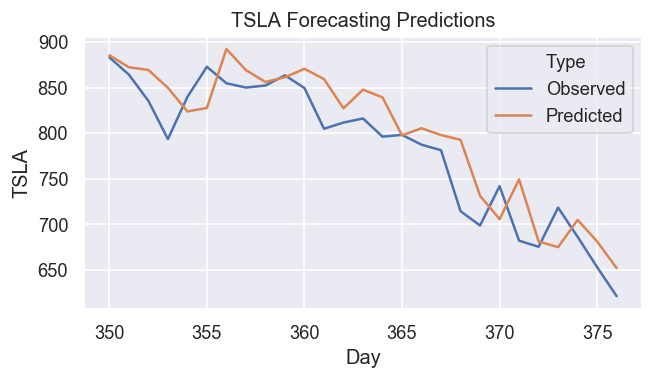

In [74]:
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':120})

# Plot
sns.lineplot(data= rf_pred[rf_pred['Day'] > 349], x="Day", y="TSLA", hue="Type")
plt.title("TSLA Forecasting Predictions")
plt.show()

# XGBoost

In [76]:
import xgboost
from sklearn.model_selection import GridSearchCV

Let's train our XGBoost model and use GridSearch to select the best parameters. (This may take a while to run)

In [77]:
training_size = 350
horizon = 1

# Training data
X = tsla_df.iloc[:training_size-horizon,1:]
y = tsla_df.iloc[:training_size-horizon,0] 

# Parameters
params = {'colsample_bytree':[0.4,0.6,0.8],
         'gamma':[0,0.03,0.1,0.3],
         'min_child_weight':[1.5,6,10],
         'learning_rate':[0.1,0.07],
         'max_depth':[3,5],
         'n_estimators':[100],
         'reg_alpha':[1e-5, 1e-2,  0.75],
         'reg_lambda':[1e-5, 1e-2, 0.45],
         'subsample':[0.6,0.95],
         'random_state':[0]} 

# XGBoost  
regr = GridSearchCV(xgboost.XGBRegressor(), params)
regr.fit(X, y)     

In [ ]:
regr.best_params_

In [ ]:
# {'colsample_bytree': 0.8,
#  'gamma': 0.1,
#  'learning_rate': 0.1,
#  'max_depth': 3,
#  'min_child_weight': 1.5,
#  'n_estimators': 100,
#  'random_state': 0,
#  'reg_alpha': 1e-05,
#  'reg_lambda': 1e-05,
#  'subsample': 0.6}

In [79]:
# XGBoost   
training_size = 350

params = {'colsample_bytree': 0.8,
         'gamma': 0.1,
         'learning_rate': 0.1,
         'max_depth': 3,
         'min_child_weight': 1.5,
         'n_estimators': 100,
         'random_state': 0,
         'reg_alpha': 1e-05,
         'reg_lambda': 1e-05,
         'subsample': 0.6,
         'random_state':0}

#params = {'n_estimators': 100, 'random_state':0}

# Split train and test sets (test = 30 days)
X = tsla_df.iloc[:,1:]
y = tsla_df.iloc[:,0] 
X_train, X_test = X.iloc[0:training_size,:], X.iloc[training_size:X.shape[0],:]
y_train, y_test = y[0:training_size], y[training_size:len(y)]

# train model
regr = xgboost.XGBRegressor(**params)
regr.fit(X_train.values, y_train)  

train_pred = regr.predict(X_train.values)
y_true = y_train.values
test_pred = []

# walk-forward predictions (except last record)
for t in range(training_size, X.shape[0]-1):
    regr.fit(X.iloc[:t,:].values, y[:t]) 
    yhat = regr.predict(X.iloc[t,:][:,None].T) #reshape with broadcasting
    test_pred.append(yhat)
    obs = y[t]
rmse = math.sqrt(mean_squared_error(y_test.values[:-1], test_pred))
print(f"Test RMSE: {round(rmse, 3)}")

Test RMSE: 0.044


The XGBoost model outperformed our ARIMA model's baseline of 0.053 by 17% with an RMSE of 0.044.

# LSTM 

Long Short Term Memory networks — usually just called “LSTMs” — are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997) and were refined and popularized by many people in the following work. They work tremendously well on a large variety of problems and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

In [15]:
# LSTM
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [16]:
import tensorflow as tf

In [29]:
# Move target variable to the end
tsla_cols = ['TSLA', 'Volume', 'MACD', 'MACD_SIGNAL', 'MACD_HIST',
       'MOMENTUM', 'RSI', 'EMA', 'MA10', 'MA21', 'MA50', 'STD_DEV', 'SPY',
       'Sentiment Score', 'Comment Volume', 'Day', 'Monthday', 'Week', 'Weekday',
       'Month', 'Year','TSLA(t+1)']
tsla_df = tsla_df[tsla_cols]

#### Data Prep

In [31]:
# Training data
training_size = 350
df = tsla_df.copy()

# Drop last record without value for target variable
df = df.iloc[:-1,:]

# train - test split
train_df, test_df = df.iloc[:training_size, :], df.loc[training_size:, :]

In [32]:
# Prep data
values = df.values
values = values.astype('float64')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

### Define and Fit Model

In [36]:
# Fit an LSTM with our multivariate input data
values = scaled
n_train_days = 350
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(350, 1, 21) (350,) (26, 1, 21) (26,)


We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting TSLA's price. The input shape will be 1 time step with 26 features.

The model will be fit for 50 training epochs with a batch size of 5. The internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful, in this case 5 days or one week in the stock market.


Train on 350 samples, validate on 26 samples
Epoch 1/50
 - 1s - loss: 0.1166 - val_loss: 0.0942
Epoch 2/50
 - 0s - loss: 0.0945 - val_loss: 0.0915
Epoch 3/50
 - 0s - loss: 0.0919 - val_loss: 0.0850
Epoch 4/50
 - 0s - loss: 0.0896 - val_loss: 0.0813
Epoch 5/50
 - 0s - loss: 0.0894 - val_loss: 0.0827
Epoch 6/50
 - 0s - loss: 0.0883 - val_loss: 0.0810
Epoch 7/50
 - 0s - loss: 0.0872 - val_loss: 0.0878
Epoch 8/50
 - 0s - loss: 0.0853 - val_loss: 0.0895
Epoch 9/50
 - 0s - loss: 0.0851 - val_loss: 0.0880
Epoch 10/50
 - 0s - loss: 0.0849 - val_loss: 0.0864
Epoch 11/50
 - 0s - loss: 0.0853 - val_loss: 0.0912
Epoch 12/50
 - 0s - loss: 0.0854 - val_loss: 0.0900
Epoch 13/50
 - 0s - loss: 0.0849 - val_loss: 0.0882
Epoch 14/50
 - 0s - loss: 0.0849 - val_loss: 0.0884
Epoch 15/50
 - 0s - loss: 0.0850 - val_loss: 0.0864
Epoch 16/50
 - 0s - loss: 0.0843 - val_loss: 0.0864
Epoch 17/50
 - 0s - loss: 0.0838 - val_loss: 0.0846
Epoch 18/50
 - 0s - loss: 0.0848 - val_loss: 0.0830
Epoch 19/50
 - 0s - loss: 0

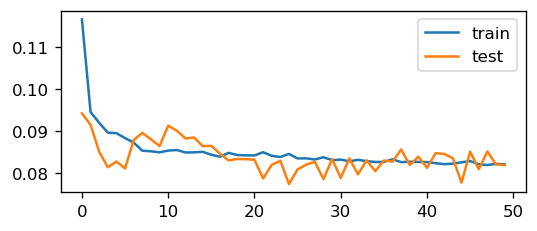

In [37]:
# Now we can define and fit our LSTM model.
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Evaluate Model

In [75]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.043


The LSTM outperformed our ARIMA model's baseline of 0.053 by 19% with an RMSE of 0.043.

In conclusion, the LSTM is our champion model, outperforming our Random Forest and XGBoost models by 6.5% and 2.3%, respectively.